First import the required packages to analyze the provided data.


In [39]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

Next, load the provided data (downloaded as a .csv file) as a dataframe.

In [26]:
#load the data as a dataframe
shoes = pd.read_csv("2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")

Now I do some quick checks of he data to make sure that it has loaded properly and get a feel for what I am working with. I will also do some cursory checks to make sure that there are no zero or empty entries in the data that could be throwing off the results.

In [27]:
#check the data to see that it has loaded properly, what it contains, column labels, etc.
shoes.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [28]:
#Check for any zeros in the dataset (always a good thing to check!)
shoes.eq(0).any().any()

False

In [29]:
#Check for any null entries and print the row/column indices of the null values if they exist
np.where(pd.isnull(shoes))

(array([], dtype=int64), array([], dtype=int64))

The above lines tell me that there are no zero entries in the dataframe and no null values (because the 'where' function returned empty arrays), so no further investigation is necessary in this direction.

Next, I will look at some summary statistics of the data to begin investigating where the naive calculation of average order value (AOV) is going wrong.

In [30]:
#get some summary statistics of each column
shoes.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


The above output clearly shows the naive AOV calculation of $3,145.13 reflected in the mean of the 'order_amount' column. This is undoubtedly too high for sneaker sales, and some other data from this output hints at a potential explanation. The max value of the 'order_amount' column is extremely high while the thrid quartile value is more reasonable, leading me to believe that there is one or more outlier in the data driving up the mean value of the 'order_amount' column. The same goes for the 'total_items' column, where it seems that the mean of 'order_amount' may be driven up by one or more outlier stores that recorded very large orders (which naturally would come with very large revenue).

Instead of calculating the AOV as simply the mean value of the 'order_amount' column, I propose (based on information from [Shopify's own blog](https://www.shopify.com.ng/blog/average-order-value#averageorder)) that a better calculation of AOV is the total revenue divided by the number of orders from each store. Once calculated for each store, an average may be taken to find the average AOV for the 30-day period when considering all sneaker shops.

I calculate a new 'corrected_AOV' value for each store by grouping the data by store and finding the sum of order amounts and dividing that value by the number of orders: 

In [37]:
#Group data by 'shop_id' and find the total revenue as the sum of the 'order_amount' entries for each store
#and the number of orders as the number of 'order_id' entries for each store.
#Divide these values to calculate the 'corrected_AOV' value.

orders_per_store = shoes.groupby('shop_id')['order_id'].count()
revenue_per_store = shoes.groupby('shop_id')['order_amount'].sum()

corrected_AOV = revenue_per_store/orders_per_store

#Now check the summary stats for the calculated AOV
corrected_AOV.describe()


count       100.000000
mean       3136.834088
std       23935.881130
min         162.857143
25%         263.675962
50%         308.889758
75%         336.628352
max      235101.490196
dtype: float64

The above shows the statistics for the newly calculated 'corrected_AOV' value, but I see that its mean is still very high. This makes sense since I previously identified that there are likely outlier shops that are driving the average way up, and still have done nothing to investigate them. So let's check out how many outliers are in the data and get some more details on those shops.

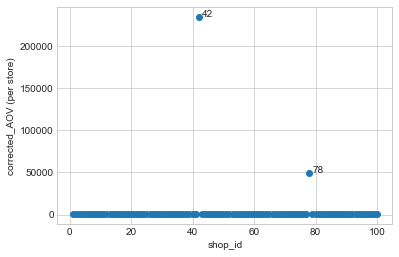

In [78]:
#Make some quick plots to identify the outlier shop(s)
#plt.scatter(shoes['total_items'], shoes['order_amount'])

x = np.arange(start=1, stop=101, step=1) 
#The above line takes advanage of the fact that the revenue_per_store variable is sorted by store_id,
#which we know runs from 1 to 100

plt.scatter(x, corrected_AOV)
plt.xlabel("shop_id")
plt.ylabel("corrected_AOV (per store)")

for i in range(len(x)):
    if corrected_AOV.iloc[i] > 3000:
        plt.annotate(str(i+1), (x[i+1], corrected_AOV[i+1] + 0.2))
    else:
        continue


The annotations on the outlier points on the above plot of corrected_AOV (sum of 'order_amount' divided by the number of orders recorded at each store) versus shop_id represent the shop_id. This clearly shows that some outlier behavior is happening at the stores with shop_id values of 42 and 78. So let's take a closer look at them!

In [80]:
print(shoes.loc[shoes['shop_id'] == 42])

      order_id  shop_id  user_id  order_amount  total_items payment_method  \
15          16       42      607        704000         2000    credit_card   
40          41       42      793           352            1    credit_card   
60          61       42      607        704000         2000    credit_card   
308        309       42      770           352            1    credit_card   
409        410       42      904           704            2    credit_card   
520        521       42      607        704000         2000    credit_card   
834        835       42      792           352            1           cash   
835        836       42      819           704            2           cash   
938        939       42      808          1056            3    credit_card   
979        980       42      744           352            1          debit   
1104      1105       42      607        704000         2000    credit_card   
1362      1363       42      607        704000         2000    c

In [82]:
print(shoes.loc[shoes['shop_id'] == 78])

      order_id  shop_id  user_id  order_amount  total_items payment_method  \
160        161       78      990         25725            1    credit_card   
490        491       78      936         51450            2          debit   
493        494       78      983         51450            2           cash   
511        512       78      967         51450            2           cash   
617        618       78      760         51450            2           cash   
691        692       78      878        154350            6          debit   
1056      1057       78      800         25725            1          debit   
1193      1194       78      944         25725            1          debit   
1204      1205       78      970         25725            1    credit_card   
1259      1260       78      775         77175            3    credit_card   
1384      1385       78      867         25725            1           cash   
1419      1420       78      912         25725            1     

Excusing the somewhat messy formating, it can be easily seen that these stores have some questionable qualities. The store with shop_id=42 has frequent orders of 2000 items, which, even though the items are reasonably priced, drives up the stores's revenue to very high values. On the other hand, the store corresponding to shop_id=78 has more reasonable order sizes, but appears to be charging $25,725 per pair of shoes! There may be reasonable explanations for these values- perhaps store 42 is a wholesaler shipping out popular brands to large brick-and-mortar locations and store 78 is a very high-end fashion designer catering to wealthy clientele, or a simple typo or bug is present in the data for these stores (with the latter option probably the most likely).

However, without the ability to ask the stores or employees responsible for the data acquisition, it seems safest to omit the order data from these stores when calculating the AOV for our shoe stores. Let's do that and re-calculate the AOV:

In [88]:
#check the shape of the dataframe before filtering
print("dataframe shape before filtering: ", shoes.shape)

#create a new data frame with outlier stores dropped
shoes_filtered = shoes[shoes['shop_id'] != 42]
shoes_filtered = shoes_filtered[shoes_filtered['shop_id'] != 78]

#check the shape of the dataframe after filtering
print("dataframe shape after filtering: ", shoes_filtered.shape)

dataframe shape before filtering:  (5000, 7)
dataframe shape after filtering:  (4903, 7)


The data from the oddly performing stores has been filtered out. Now I will finally calculate the corrected AOV for the shoe stores!

In [91]:
#find the number of orders placed at each store and the total revenue earned at each store
#(this could also be done by removing elements from the previously calculated corrected_AOV array,
#but for the sake of clarity I will recalculate the AOV for each store using the filtered data)
orders_per_store_filtered = shoes_filtered.groupby('shop_id')['order_id'].count()
revenue_per_store_filtered = shoes_filtered.groupby('shop_id')['order_amount'].sum()

corrected_AOV_filtered = revenue_per_store_filtered/orders_per_store_filtered

corrected_AOV_filtered.describe()

count     98.000000
mean     299.682399
std       50.896733
min      162.857143
25%      262.661218
50%      308.827696
75%      334.631226
max      403.545455
dtype: float64

In [95]:
print("The AOV averaged across all stores is", np.round(corrected_AOV_filtered.mean(), 2))

The AOV averaged across all stores is 299.68


That looks much more reasonable! This tells us that the AOV averaged across all of our shoe stores, after removing outliers, is $299.68

## Summary

#### a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

There were several issues with the naive approach of using the mean value of the 'order_amount' column as the AOV. First an foremost, there was no treatment done to the data to test for outliers when there were in fact two stores exhibiting extreme behavior in comparison to the others, with one dealing with extreme item volume and another dealing with extreme prices. Without the ability to verify the data from these two stores, I believe that it is safest to remove them from consideration when calculating the AOV across all of the sneaker stores. Second, while the naive approach used to calculate the AOV will result in a decent estimation, a more correct approach is to consider the total revenue and number of orders from each sneaker store.

#### b. What metric would you report for this dataset?

To distill the dataset into a single metric, I would report the corrected average AOV as the total revenue of each store divided by the total number of orders from each store, averaged across all sneaker stores in the dataset with the two identified outliers removed (at least until their sales data can be verified or corrected).

#### c. What is its value?

I found the corrected AOV averaged over the sneaker stores to be **$299.68**.